# Hand-Eye Calibration

This notebook provides hand-eye calibration for the AprilTag minimal working example. It is intended for development use only. The resulting hand-eye transformation matrix (`hand_eye_calibration.npy`) will be hard-coded into the main notebook (src\ac_training_lab\apriltag_hardware_demo\apriltag_hardware_demo.ipynb) for system operation.

## Requirements

In [15]:
%pip install numpy scipy opencv-python pillow matplotlib gradio-client

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [306]:
import time

def lock_cobot_position(client, user_id, speed=10):
    """
    Queries current cobot angles and sends them back to lock the position.

    Parameters:
    - client: your gradio client
    - user_id: ID for the prediction queue
    - speed: speed for send_angles (default: 10)
    """
    # Step 1: query current angles
    result = client.predict(
        user_id=user_id,
        api_name="/query_coords"
    )
    
    print("Raw response:", result)
    
    if not result or not isinstance(result, dict) or "coords" not in result:
        print("Failed to get coordinates from cobot.")
        return

    coords = result["coords"]
    print("Queried current coords:", coords)

    # Step 2: send current angles to hold position
    response = client.predict(
        user_id=user_id,
        api_name="/send_angles",
        data={"angles": coords[3:6], "speed": speed}
    )
    
    print("Sent angles to lock position:", coords[3:6])
    print("Server response:", response)


## Connecting to the Cobot

We first define some helper functions to display result and images. 

In [232]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def display_image(image_path):
	try:
		img = Image.open(image_path).convert("RGB")
		plt.imshow(img)
		plt.title("Cobot view")
		plt.show()
	except Exception as e:
		print(f"An error occurred: {e}")

def display_result(result):
	queue_status_str = result[-1].replace('\n', ' ')
	print(f"queue status: {queue_status_str}")
	print(f"response json: {None if result[0] is None else json.loads(result[0])}")
	if len(result) == 3:
		if result[1] is None:
			return
		display_image(result[1]['value'])

Connect to the cobot to begin data collection and calibration.

In [233]:
from gradio_client import Client
import uuid
import getpass  

USER_ID = str(uuid.uuid4())
print(f"Your user id: {USER_ID}")

hf_token = getpass.getpass("Enter your Hugging Face Token:")

client = Client(
    "AccelerationConsortium/cobot280pi-gradio-g9sv",
    hf_token=hf_token
)

client.view_api()

result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)

Your user id: a49b1c97-0878-48a9-b539-5fcec9a0c74b
Loaded as API: https://accelerationconsortium-cobot280pi-gradio-g9sv.hf.space ✔
Client.predict() Usage Info
---------------------------
Named API endpoints: 15

 - predict(user_id, api_name="/query_angles") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_coords") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_gripper") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_camera") -> (response, value_72, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  

## Data Collection Instructions

1. Print a checkerboard and stick it to a wall or stable surface.

2. Run the code cells about **20 times**. Each time:

   - Run the **first cell** to release all servos so you can move the cobot by hand.  
   - Adjust the cobot so the checkerboard is clearly visible. Use the **second cell** to check the camera view.  
   - Hold the cobot still and run the **third cell** to save the image and pose to a JSON file.

3. Try different angles and positions to improve calibration accuracy.




### 1. Release All Servos

In [258]:
result = client.predict(
    user_id=USER_ID,
    api_name="/release_servos"
)
display_result(result)


queue status: Your turn! Time remaining: 12.62 seconds.
response json: {'success': True, 'command': 'control/release_servos'}


In [256]:
INITIAL_HOME_POSE = {
    "angle0": 0,
    "angle1": 0,
    "angle2": 0,
    "angle3": 0,
    "angle4": 0,
    "angle5": 0,
    "movement_speed": 50
}
result = client.predict(
    user_id=USER_ID,
    **INITIAL_HOME_POSE, 
    api_name="/control_angles"
)
display_result(result)


queue status: Your turn! Time remaining: 29.67 seconds.
response json: {'success': True, 'command': 'control/angles'}


In [601]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
print(result)
display_result(result)


('{\n    "success": true,\n    "coords": [\n        -188.4,\n        -111.8,\n        241.6,\n        71.62,\n        -0.98,\n        22.64\n    ],\n    "command": "query/coords"\n}', 'Your turn!\nTime remaining: 17.63 seconds.')
queue status: Your turn! Time remaining: 17.63 seconds.
response json: {'success': True, 'coords': [-188.4, -111.8, 241.6, 71.62, -0.98, 22.64], 'command': 'query/coords'}


('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\027f52eec45b57f6c796f684c4bbacebf17682276c13e89278da3076ad2d434e\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 81.95 seconds.')
queue status: Your turn! Time remaining: 81.95 seconds.
response json: {'success': True, 'command': 'query/camera'}


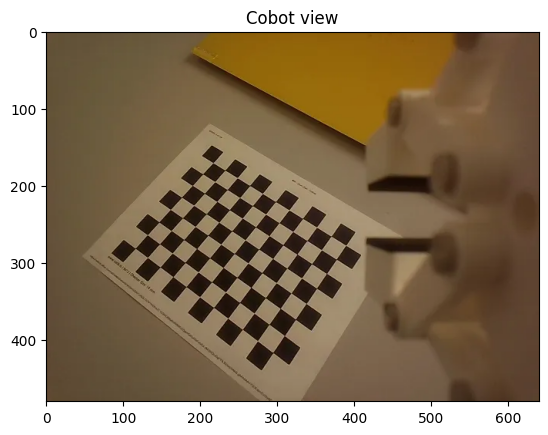

In [549]:

result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)

### 2. Save Data into JSON

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\e9c0f0763ad75faaa846282e8d2c5d381aa54fa1e216f900cf3409b8a311eed2\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 3.59 seconds.')
queue status: Your turn! Time remaining: 3.59 seconds.
response json: {'success': True, 'command': 'query/camera'}


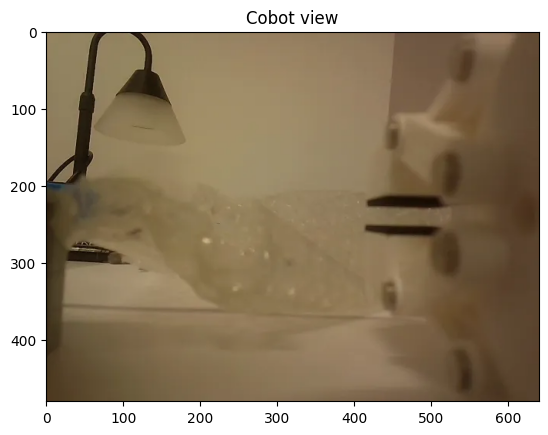

('{\n    "success": true,\n    "coords": [\n        -188.3,\n        -111.8,\n        241.6,\n        71.69,\n        -0.97,\n        22.69\n    ],\n    "command": "query/coords"\n}', 'Your turn!\nTime remaining: 0.94 seconds.')
queue status: Your turn! Time remaining: 0.94 seconds.
response json: {'success': True, 'coords': [-188.3, -111.8, 241.6, 71.69, -0.97, 22.69], 'command': 'query/coords'}
Record added to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_data.json


In [602]:
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import cv2

# Get current working directory
current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")

# Create directory to save calibration images
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")
os.makedirs(image_dir, exist_ok=True)

if not os.path.exists(json_path) or os.path.getsize(json_path) == 0:
    data_json = {"records": []}
else:
    with open(json_path, 'r') as f:
        data_json = json.load(f)

result_img = client.predict(
    user_id=USER_ID,
    api_name="/query_camera"
)
print(result_img)
display_result(result_img)

image_path = result_img[1]["value"]
image_array = cv2.imread(image_path)

# Generate a new file name for the saved image
image_id = len(data_json["records"]) + 1
save_name = f"{image_id}.jpg"
save_path = os.path.join(image_dir, save_name)
cv2.imwrite(save_path, image_array)

# Call the /query_coords API to get the cobot's pose
result_pose = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
print(result_pose)
display_result(result_pose)

# Parse the returned pose data (JSON string inside a tuple)
pose_dict = json.loads(result_pose[0])
query_coords = [float(coord) for coord in pose_dict["coords"]]

# Convert position to meters and angles to radians
x, y, z = [coord / 1000 for coord in query_coords[:3]]  # from mm to meters
rx_deg, ry_deg, rz_deg = query_coords[3:]
rx, ry, rz = np.radians([rx_deg, ry_deg, rz_deg])       # degrees to radians

# Convert rotation from Euler angles to a 3x3 rotation matrix
rotation = R.from_euler('xyz', [rx, ry, rz]).as_matrix()

# Build the 4x4 pose matrix
pose_matrix = np.eye(4)
pose_matrix[:3, :3] = rotation
pose_matrix[:3, 3] = [x, y, z]

# Create and append a new calibration record
record = {
    "image_path": os.path.join("hand_eye_calibration_images", save_name),  # relative path
    "pose_matrix": pose_matrix.tolist()
}
data_json["records"].append(record)

# Save updated records back to the JSON file
with open(json_path, 'w') as f:
    json.dump(data_json, f, indent=2)

print(f"Record added to {json_path}")



In [603]:
import os
import json

current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")

with open(json_path, 'r') as f:
    data_json = json.load(f)

if len(data_json["records"]) > 0:
    last_record = data_json["records"].pop()
    image_path = os.path.join(current_dir, last_record["image_path"])
    if os.path.exists(image_path):
        os.remove(image_path)
    with open(json_path, 'w') as f:
        json.dump(data_json, f, indent=2)
    print("Last record has been removed.")
else:
    print("No records to remove.")

Last record has been removed.


## Main function for hand-eye calibration
Next, we define helper functions for calibration, and specify the checkerboard parameters:  
- `XX`: number of inner corners along the width  
- `YY`: number of inner corners along the height  
- `L`: size of each square (in meters)

The function will perform both camera calibration and hand-eye calibration, and save the camera intrinsics into `camera_params.npy` for later use.

In [604]:
XX = 8
YY = 11
L = 0.01905  # need to check this !!!

In [605]:
def func(json_path, camera_params_path):
    with open(json_path, 'r') as f:
        data_json = json.load(f)

    if len(data_json["records"]) == 0:
        print("No records found in JSON.")
        return

    objp = np.zeros((XX * YY, 3), np.float32)
    objp[:, :2] = np.mgrid[0:XX, 0:YY].T.reshape(-1, 2)
    objp *= L

    obj_points = []
    img_points = []

    R_tool = []
    t_tool = []

    criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)

    for record in data_json["records"]:
        image_path = os.path.join(os.path.dirname(json_path), record["image_path"])

        if not os.path.exists(image_path):
            print(f"Image {image_path} not found. Skipping.")
            continue

        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        size = gray.shape[::-1]

        ret, corners = cv2.findChessboardCorners(gray, (XX, YY), None)

        if ret:
            obj_points.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
            img_points.append(corners2)

            pose_matrix = np.array(record["pose_matrix"])
            R_tool.append(pose_matrix[:3, :3])
            t_tool.append(pose_matrix[:3, 3])
        else:
            print(f"Chessboard not detected in {image_path}")

    if len(obj_points) == 0:
        print("No valid images for calibration.")
        return

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points,
        img_points,
        size,
        cameraMatrix=None,
        distCoeffs=None
    )

    np.save(camera_params_path, {
        "camera_matrix": K,
        "dist_coeff": dist
    })
    print(f"Saved camera parameters to {camera_params_path}")

    R_ce, t_ce = cv2.calibrateHandEye(R_tool, t_tool, rvecs, tvecs, cv2.CALIB_HAND_EYE_TSAI)
    print(f"{len(obj_points)} valid checkerboard images were used for calibration.")

    return R_ce, t_ce


Finally, run `func()` to compute the hand-eye calibration and save the resulting matrices.

In [606]:
data_dir = os.getcwd()
json_path = os.path.join(data_dir, "hand_eye_calibration_data.json")
camera_params_path = os.path.join(data_dir, "camera_params.npy")
hand_eye_path = os.path.join(data_dir, "hand_eye_calibration.npy")

R_ce, t_ce = func(json_path, camera_params_path)

if R_ce is not None and t_ce is not None:
    hand_eye_params = {
        "rotation_matrix": R_ce,
        "translation_vector": t_ce
    }
    np.save(hand_eye_path, hand_eye_params)
    print(f"Saved hand-eye calibration to {hand_eye_path}")

Saved camera parameters to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\camera_params.npy
18 valid checkerboard images were used for calibration.
Saved hand-eye calibration to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration.npy


## JSON Data Management

### Clear JSON File and Image Folder

In [307]:
import os
import json

current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")

data_json = {"records": []}
with open(json_path, 'w') as f:
    json.dump(data_json, f, indent=2)
print(f"JSON file at {json_path} has been cleared and reset.")

if os.path.exists(image_dir):
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print(f"All files in {image_dir} have been deleted.")
else:
    print(f"Image folder does not exist: {image_dir}")



JSON file at f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_data.json has been cleared and reset.
All files in f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_images have been deleted.
